# Klasyfikator gestów oparty na Random Forest Classifier
#### Model do rozpoznawania gestów magicznej różdżki na podstawie danych IMU (akcelerometr + żyroskop)

In [23]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from micromlgen import port
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import pickle
import joblib

In [ ]:
def load_data_from_directory(directory):
    data = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)

            data.append(df)
            labels.append(directory)
    return data, labels

### Wczytywanie datasetu

In [ ]:
avada_data, avada_labels = load_data_from_directory('avada_new')
lumos_data, lumos_labels = load_data_from_directory('lumos_new')
alohomora_data, alohomora_labels = load_data_from_directory('alohomora_new')
wingardium_data, wingardium_labels = load_data_from_directory('wingardium_new')
mystery_data, mystery_labels = load_data_from_directory('mystery')

## Wizualizacja przykładowych danych

In [26]:
def brief_plot(data):
    rows = len(data) // 4
    fig, ax = plt.subplots(rows,3,figsize=(16,12))
    for i in range(rows):
        for j in range(3):
            ax[i,j].plot(data[3*i+j]["time"], data[3*i+j].iloc[:,1:])

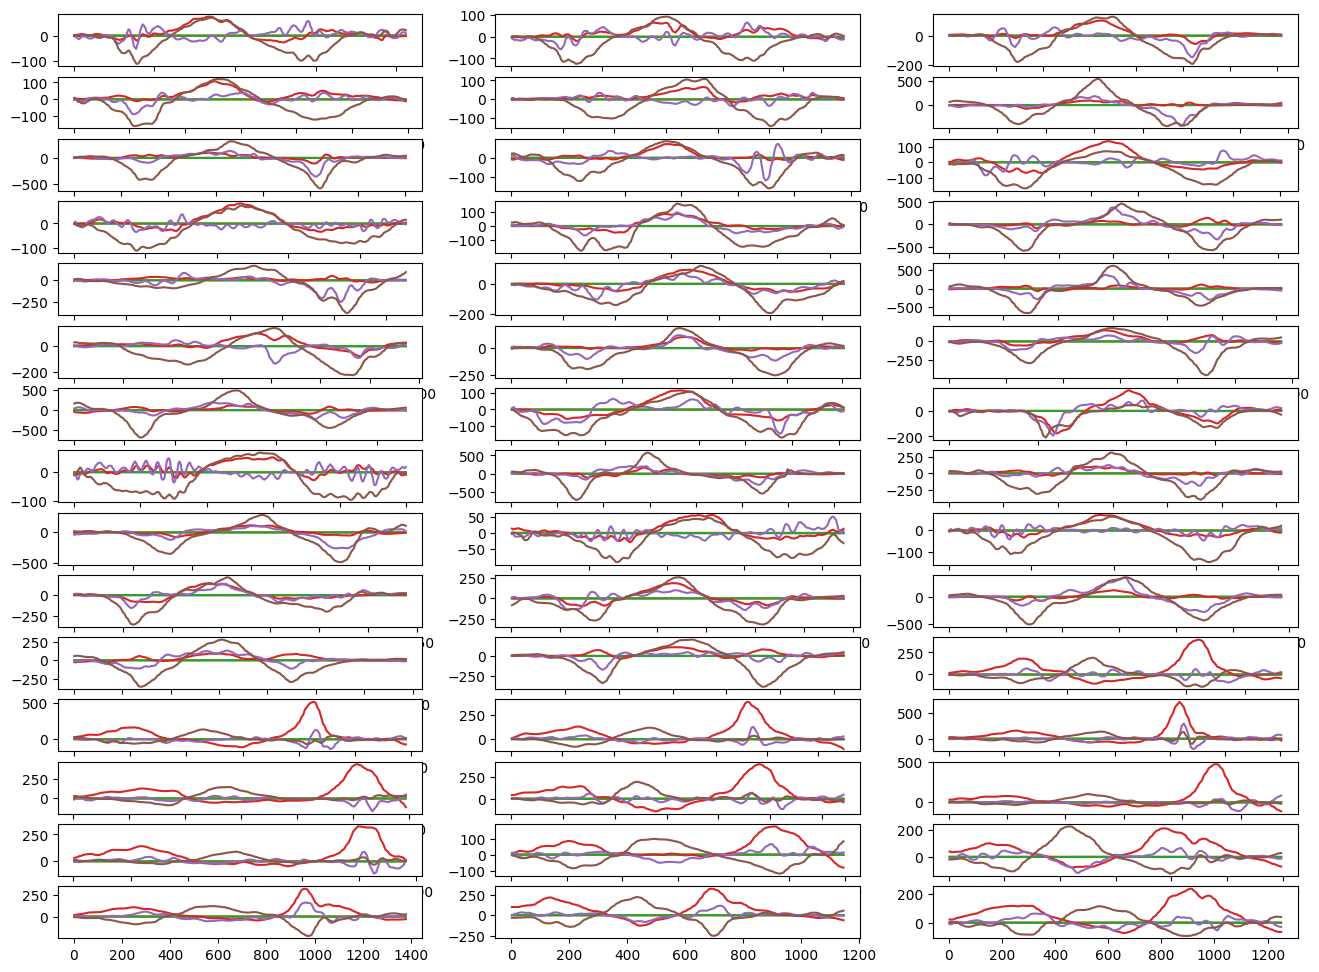

In [27]:
brief_plot(avada_data)

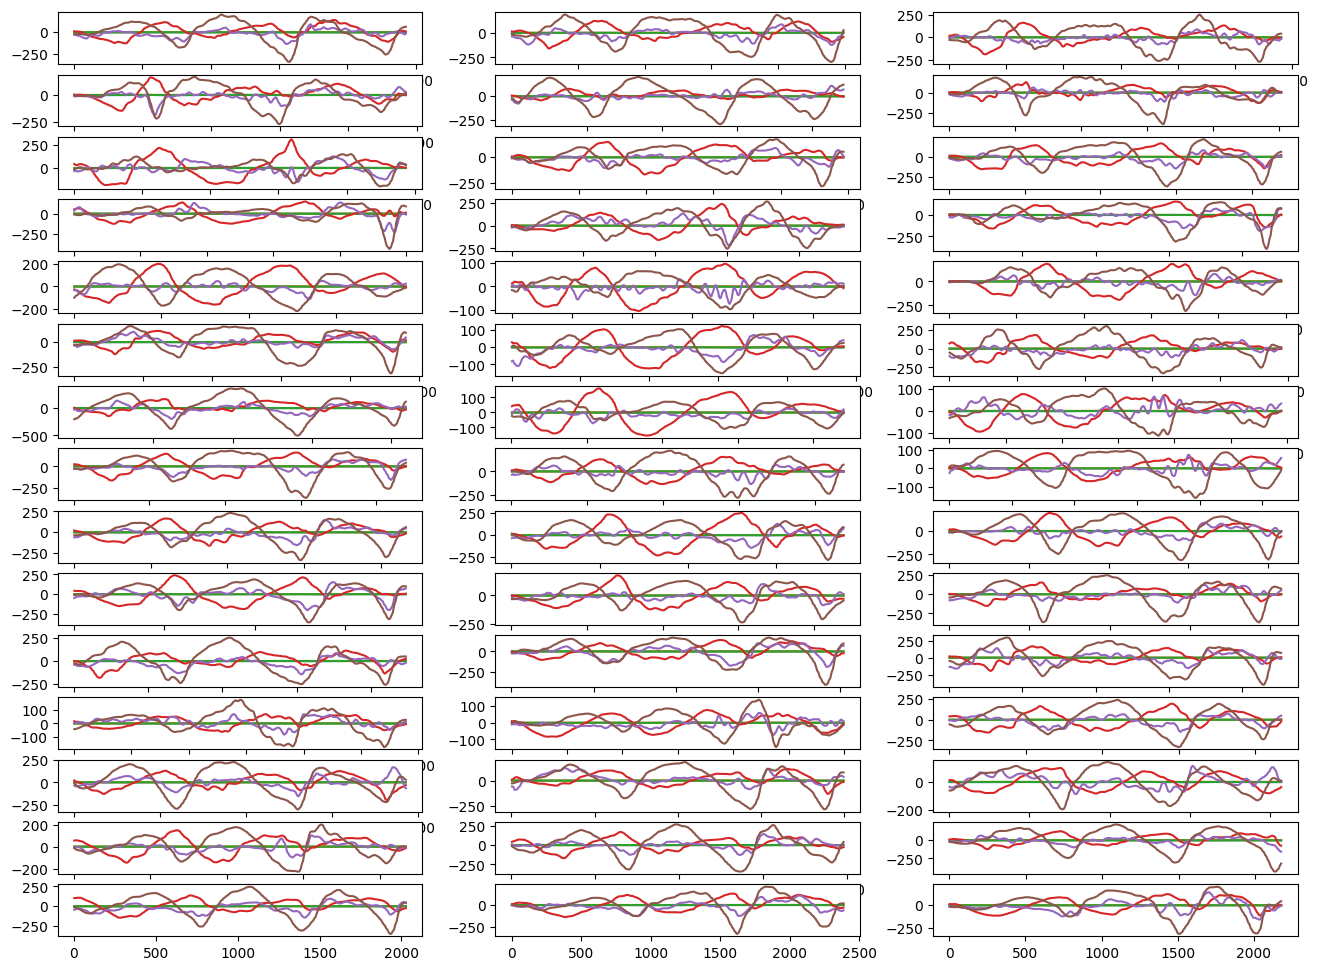

In [ ]:
brief_plot(lumos_data)

In [29]:
X = avada_data + lumos_data + alohomora_data + wingardium_data + mystery_data
y = avada_labels + lumos_labels + alohomora_labels + wingardium_labels + mystery_labels

## Analiza długości sekwencji

Alohomora: min=163, max=314, avg=239.6
Lumos: min=93, max=328, avg=175.8
Wingardium: min=135, max=278, avg=200.1
Avada: min=127, max=313, avg=183.8
Mystery: min=230, max=375, avg=290.3

Wszystkie: min=93, max=375, avg=218.2


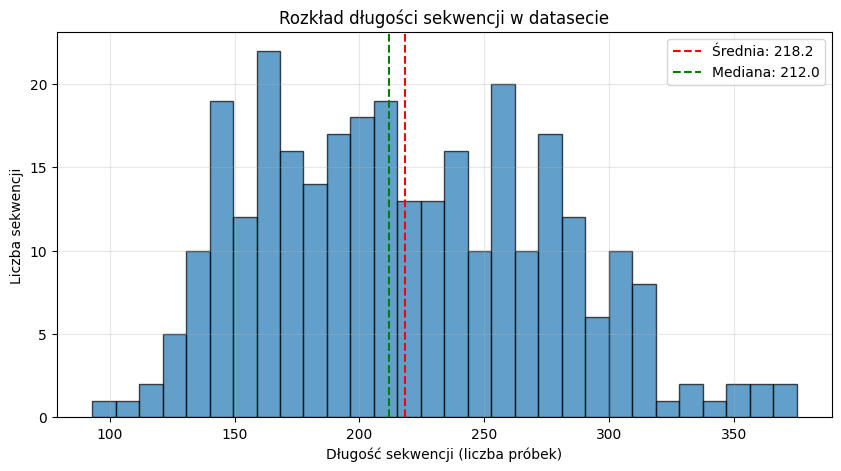

In [30]:
# Sprawdź długości sekwencji (liczba próbek czasowych)
all_lengths = []
for data, name in [(alohomora_data, 'Alohomora'), 
                    (lumos_data, 'Lumos'), 
                    (wingardium_data, 'Wingardium'), 
                    (avada_data, 'Avada'),
                    (mystery_data, 'Mystery')]:
    lengths = [len(df) for df in data]
    all_lengths.extend(lengths)
    print(f"{name}: min={min(lengths)}, max={max(lengths)}, avg={np.mean(lengths):.1f}")

print(f"\nWszystkie: min={min(all_lengths)}, max={max(all_lengths)}, avg={np.mean(all_lengths):.1f}")

# Wizualizacja rozkładu długości
plt.figure(figsize=(10, 5))
plt.hist(all_lengths, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Długość sekwencji (liczba próbek)')
plt.ylabel('Liczba sekwencji')
plt.title('Rozkład długości sekwencji w datasecie')
plt.axvline(np.mean(all_lengths), color='r', linestyle='--', label=f'Średnia: {np.mean(all_lengths):.1f}')
plt.axvline(np.median(all_lengths), color='g', linestyle='--', label=f'Mediana: {np.median(all_lengths):.1f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Preprocessing - padding/obcinanie do stałej długości

In [ ]:
MAX_SEQUENCE_LENGTH = 200  # musi być równe SAMPLE_COUNT w kodzie Arduino

print(f"Ustawiona maksymalna długość sekwencji: {MAX_SEQUENCE_LENGTH}")

def pad_or_truncate_dataframe(df, max_length):
    """
    Dopasowuje DataFrame do stałej długości
    - Jeśli za krótki: powtarza ostatni wiersz (lepsze niż zeros)
    - Jeśli za długi: obcina do max_length
    """
    current_length = len(df)
    
    if current_length < max_length:
        # Padding - powtórz ostatni wiersz
        last_row = df.iloc[-1:].copy()
        padding_needed = max_length - current_length
        padding = pd.concat([last_row] * padding_needed, ignore_index=True)
        return pd.concat([df, padding], ignore_index=True)
    else:
        # Obcinanie do max_length
        return df.iloc[:max_length]

# Zastosuj padding/obcinanie
print("\nPrzygotowywanie danych...")
X_processed = []
for df in X:
    df_padded = pad_or_truncate_dataframe(df, MAX_SEQUENCE_LENGTH)
    X_processed.append(df_padded)

# Sprawdź czy wszystkie mają tę samą długość
lengths_after = [len(df) for df in X_processed]
print(f"Długości po preprocessingu: min={min(lengths_after)}, max={max(lengths_after)}")
print(f"Liczba próbek: {len(X_processed)}")
print(f"Wymiary przykładowego DataFrame: {X_processed[0].shape}")

# Zastąp X przetworzonymi danymi
X = X_processed

Ustawiona maksymalna długość sekwencji: 200

Przygotowywanie danych...
Długości po preprocessingu: min=200, max=200
Liczba próbek: 301
Wymiary przykładowego DataFrame: (200, 7)


In [ ]:
# WAŻNE: Usuń kolumnę 'time' przed flatten (jak w CNN!)
print(f"Flattening {len(X)} próbek...")

# Usuń kolumnę time i flatten tylko dane IMU (6 kolumn)
X_flattened = []
for df in X:
    # Drop column 0 (time), keep only columns 1-6 (ax,ay,az,gx,gy,gz)
    imu_data = df.iloc[:, 1:7].values.flatten()
    X_flattened.append(imu_data)

# Sprawdź wymiary
print(f"Przykładowy wektor cech: {X_flattened[0].shape}")
print(f"Liczba cech: {len(X_flattened[0])}")
print(f"Oczekiwana liczba cech: {MAX_SEQUENCE_LENGTH * 6}")

if len(X_flattened[0]) != MAX_SEQUENCE_LENGTH * 6:
    print(f"BŁĄD: Niezgodność wymiarów!")
    print(f"   Expected: {MAX_SEQUENCE_LENGTH * 6}, Got: {len(X_flattened[0])}")

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X_flattened, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTreningowy: {len(X_train)} próbek")
print(f"Testowy: {len(X_test)} próbek")
print(f"Rozkład klas w zbiorze treningowym: {np.unique(y_train, return_counts=True)}")

Flattening 301 próbek...
Przykładowy wektor cech: (1200,)
Liczba cech: 1200
Oczekiwana liczba cech: 1200

Treningowy: 240 próbek
Testowy: 61 próbek
Rozkład klas w zbiorze treningowym: (array(['alohomora_new', 'avada_new', 'lumos_new', 'mystery',
       'wingardium_new'], dtype='<U14'), array([48, 48, 48, 48, 48]))


In [33]:
param_grid= {
    'n_estimators': list(range(10,26,2)),
    'min_samples_split': [2,4,5,8]
            }

In [ ]:
model = RandomForestClassifier(random_state=42)
grid_search_cv = GridSearchCV(model, param_grid, cv=3,scoring='accuracy',return_train_score=True)
grid_search_cv.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'min_samples_split': [2, 4, ...], 'n_estimators': [10, 12, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,14


In [35]:
grid_search_cv.best_params_

{'min_samples_split': 4, 'n_estimators': 14}

In [36]:
grid_search_cv.best_score_

np.float64(0.975)

## Ewaluacja modelu RandomForest na zbiorze testowym

In [37]:
# Pobierz najlepszy model z GridSearch
best_model = grid_search_cv.best_estimator_

# Predykcja na zbiorze testowym
y_pred = best_model.predict(X_test)

# Dokładność na zbiorze testowym
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Best CV Score: {grid_search_cv.best_score_:.4f}")

# Raport klasyfikacji
class_names = ['alohomora_new', 'avada_new', 'lumos_new', 'wingardium_new', 'mystery']
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Test Accuracy: 0.9672
Best CV Score: 0.9750

Classification Report:
                precision    recall  f1-score   support

 alohomora_new       1.00      1.00      1.00        12
     avada_new       1.00      1.00      1.00        12
     lumos_new       0.86      1.00      0.92        12
wingardium_new       1.00      0.92      0.96        13
       mystery       1.00      0.92      0.96        12

      accuracy                           0.97        61
     macro avg       0.97      0.97      0.97        61
  weighted avg       0.97      0.97      0.97        61



## Confusion Matrix - RandomForest

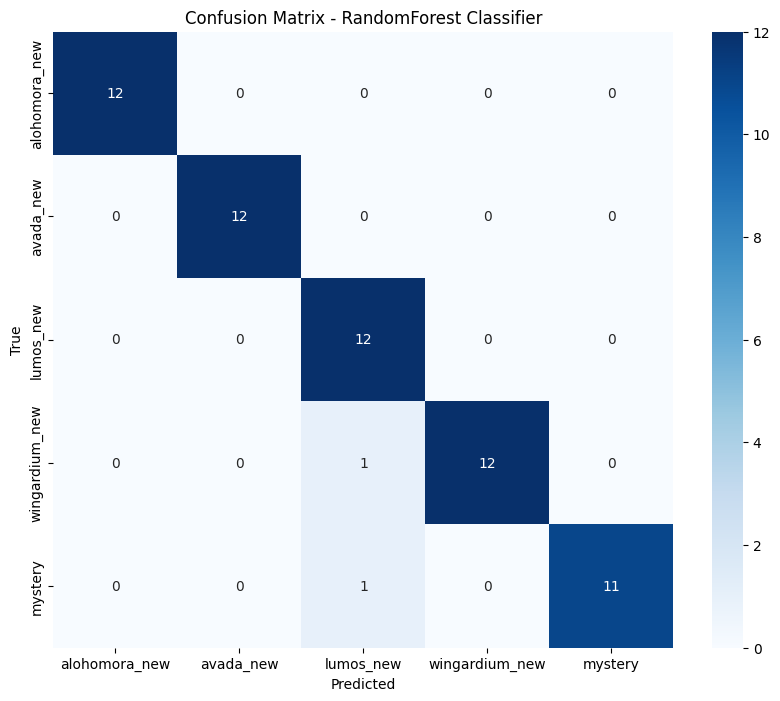


Test set size: 61
Training set size: 240
Number of features: 1200
Model parameters: {'min_samples_split': 4, 'n_estimators': 14}


In [38]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - RandomForest Classifier')
plt.show()

# Dodatkowe metryki
print(f"\nTest set size: {len(y_test)}")
print(f"Training set size: {len(y_train)}")
print(f"Number of features: {X_train[0].shape[0]}")
print(f"Model parameters: {grid_search_cv.best_params_}")

## Test pojedynczej predykcji z prawdopodobieństwami

In [39]:
# Test na przykładowej próbce
sample_idx = 0
sample = [X_test[sample_idx]]
true_label = y_test[sample_idx]

prediction = best_model.predict(sample)
probabilities = best_model.predict_proba(sample)[0]

print(f"Prawdziwa klasa: {true_label}")
print(f"Przewidziana klasa: {prediction[0]}")
print(f"\nWszystkie prawdopodobieństwa:")

# Sortujemy klasy zgodnie z class_names
label_to_idx = {label: idx for idx, label in enumerate(sorted(set(y)))}
for label in sorted(set(y)):
    idx = label_to_idx[label]
    prob = probabilities[idx]
    print(f"  {label}: {prob:.2%}")

Prawdziwa klasa: lumos_new
Przewidziana klasa: lumos_new

Wszystkie prawdopodobieństwa:
  alohomora_new: 0.00%
  avada_new: 0.00%
  lumos_new: 100.00%
  mystery: 0.00%
  wingardium_new: 0.00%


In [43]:
# Konwersja modelu RandomForest do kodu C dla Arduino
import numpy as np

# WAŻNE: Sortowanie alfabetyczne klas (sklearn robi to automatycznie)
sorted_classes = sorted(set(y))
print("Klasy w modelu (alfabetycznie):")
for i, cls in enumerate(sorted_classes):
    print(f"  {i}: {cls}")

# Remove "_new" suffix for Arduino
classmap = {i: cls.replace('_new', '') for i, cls in enumerate(sorted_classes)}
print("\nMapowanie dla Arduino:")
for k, v in classmap.items():
    print(f"  {k}: {v}")

# Port modelu do C
print("\nGenerowanie kodu C...")
c_code = port(best_model, classmap=classmap)

# Dodaj informacje o modelu do nagłówka (BEZ emotikonów!)
header_info = f"""/*
 * RandomForest Gesture Classifier
 * Generated with micromlgen
 * 
 * Model Info:
 * - n_estimators: {best_model.n_estimators}
 * - min_samples_split: {best_model.min_samples_split}
 * - max_depth: {best_model.max_depth if best_model.max_depth else 'unlimited'}
 * - CV Accuracy: {grid_search_cv.best_score_:.4f}
 * - Test Accuracy: {test_accuracy:.4f}
 * 
 * Input: {MAX_SEQUENCE_LENGTH * 6} features ({MAX_SEQUENCE_LENGTH} samples x 6 IMU columns)
 * WARNING: DO NOT include 'time' column in input!
 * 
 * Classes (alphabetically sorted):
"""

for i, cls in enumerate(sorted_classes):
    header_info += f" * {i}: {classmap[i]}\n"

header_info += """ * 
 * Usage in Arduino:
 *   #include "model_with_labels.h"
 *   Eloquent::ML::Port::RandomForest classifier;
 *   float flattenedArray[1200];  // 200 samples x 6 features
 *   String result = classifier.predictLabel(flattenedArray);
 */

"""

# Zapisz do pliku z UTF-8 encoding
output_file = "./arduCode/mainCode/model_with_labels.h"
with open(output_file, "w", encoding='utf-8') as f:
    f.write(header_info)
    f.write(c_code)

print(f"\nModel zapisany jako: {output_file}")

# Sprawdź rozmiar pliku
import os
file_size = os.path.getsize(output_file)
print(f"Rozmiar pliku: {file_size:,} bytes ({file_size/1024:.1f} KB)")

if file_size > 250000:  # 250KB
    print("\nOSTRZEZENIE: Model moze byc za duzy dla Arduino Nano 33 BLE!")
    print(f"   Flash: ~1MB, model: {file_size/1024:.1f}KB")
    print(f"   Pozostalo ~{(1024 - file_size/1024):.0f}KB na kod programu")
    print(f"\nRozwiazanie:")
    print(f"   1. Zmniejsz n_estimators (obecnie: {best_model.n_estimators})")
    print(f"   2. Ogranicz max_depth do 10-15")

# Zapisz również pełny model jako pickle (backup)
joblib.dump(best_model, './arduCode/mainCode/model_backup.pkl')
print("Backup modelu: model_backup.pkl")

print(f"\nWAZNE - SPRAWDZ ZGODNOSC:")
print(f"1. Python MAX_SEQUENCE_LENGTH: {MAX_SEQUENCE_LENGTH}")
print(f"2. Python features: {MAX_SEQUENCE_LENGTH * 6} (bez 'time')")
print(f"3. Arduino SAMPLE_COUNT: 200")
print(f"4. Arduino FLATTENED_SIZE: 200 x 6 = 1200")
print(f"\nJesli zgodne -> model gotowy do wgrania")

Klasy w modelu (alfabetycznie):
  0: alohomora_new
  1: avada_new
  2: lumos_new
  3: mystery
  4: wingardium_new

Mapowanie dla Arduino:
  0: alohomora
  1: avada
  2: lumos
  3: mystery
  4: wingardium

Generowanie kodu C...

Model zapisany jako: ./arduCode/mainCode/model_with_labels.h
Rozmiar pliku: 46,032 bytes (45.0 KB)
Backup modelu: model_backup.pkl

WAZNE - SPRAWDZ ZGODNOSC:
1. Python MAX_SEQUENCE_LENGTH: 200
2. Python features: 1200 (bez 'time')
3. Arduino SAMPLE_COUNT: 200
4. Arduino FLATTENED_SIZE: 200 x 6 = 1200

Jesli zgodne -> model gotowy do wgrania


## Eksport do Arduino (C code)

## Zapis modelu RandomForest


ANALIZA: Czy gesty są oddzielone w przestrzeni cech?


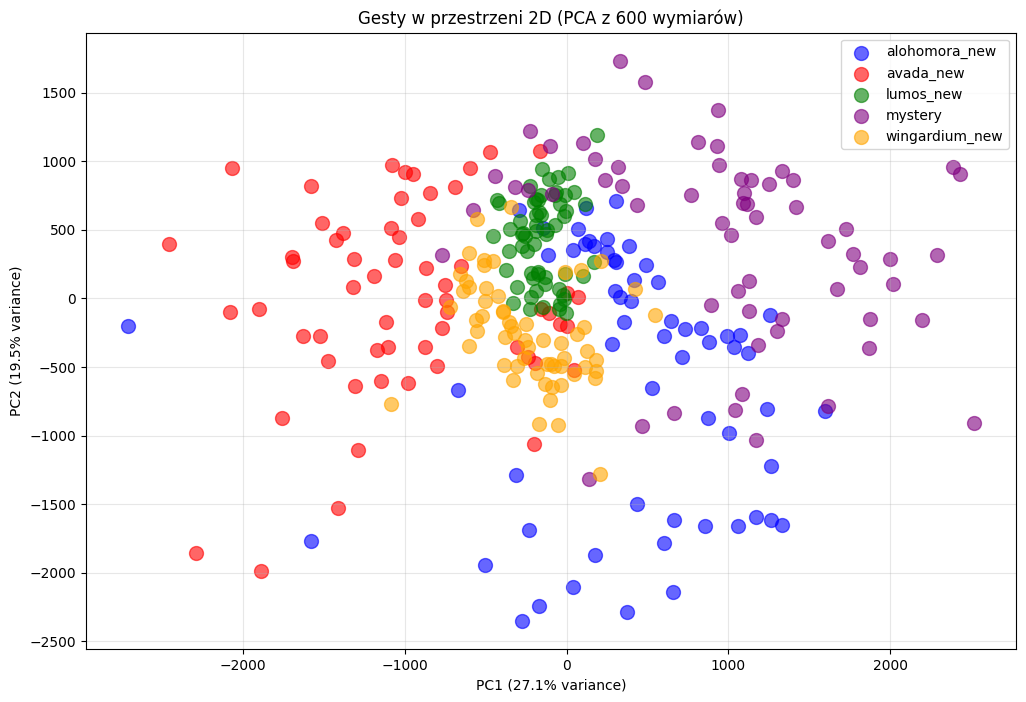


Wyjaśniona wariancja przez 2 pierwsze komponenty: 46.6%

STATYSTYKI GESTÓW (dlaczego flatten działa)

alohomora_new:
  Średnia wartość cech: -0.901
  Odchylenie std cech: 53.999
  Min wartość: -426.820
  Max wartość: 400.760
  Zakres: 827.580

avada_new:
  Średnia wartość cech: 0.834
  Odchylenie std cech: 61.811
  Min wartość: -713.010
  Max wartość: 727.420
  Zakres: 1440.430

lumos_new:
  Średnia wartość cech: 0.557
  Odchylenie std cech: 28.100
  Min wartość: -739.010
  Max wartość: 257.870
  Zakres: 996.880

mystery:
  Średnia wartość cech: -0.968
  Odchylenie std cech: 59.862
  Min wartość: -503.170
  Max wartość: 358.400
  Zakres: 861.570

wingardium_new:
  Średnia wartość cech: 4.322
  Odchylenie std cech: 31.937
  Min wartość: -291.140
  Max wartość: 262.210
  Zakres: 553.350

TOP 10 NAJWAŻNIEJSZYCH CECH (wg RandomForest)
1. Feature 207 (timestep ~29, gyro_X ): importance = 0.0376
2. Feature  83 (timestep ~11, gyro_Z ): importance = 0.0363
3. Feature 144 (timestep ~20, gyro_X

In [44]:
# Dodaj po sekcji "Flatten"

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === ANALIZA: Dlaczego model działa mimo flatten? ===

print("\n" + "="*70)
print("ANALIZA: Czy gesty są oddzielone w przestrzeni cech?")
print("="*70)

# 1. PCA - zredukuj 600 wymiarów do 2D dla wizualizacji
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flattened)

# 2. Wizualizacja w 2D
plt.figure(figsize=(12, 8))
colors = {'alohomora_new': 'blue', 'avada_new': 'red', 
          'lumos_new': 'green', 'wingardium_new': 'orange', 
          'mystery': 'purple'}

for label in np.unique(y):
    mask = np.array(y) == label
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                c=colors[label], label=label, alpha=0.6, s=100)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Gesty w przestrzeni 2D (PCA z 600 wymiarów)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nWyjaśniona wariancja przez 2 pierwsze komponenty: {sum(pca.explained_variance_ratio_):.1%}")

# 3. Analiza statystyk per gest
print("\n" + "="*70)
print("STATYSTYKI GESTÓW (dlaczego flatten działa)")
print("="*70)

for label in np.unique(y):
    mask = np.array(y) == label
    X_label = np.array(X_flattened)[mask]
    
    print(f"\n{label}:")
    print(f"  Średnia wartość cech: {X_label.mean():.3f}")
    print(f"  Odchylenie std cech: {X_label.std():.3f}")
    print(f"  Min wartość: {X_label.min():.3f}")
    print(f"  Max wartość: {X_label.max():.3f}")
    print(f"  Zakres: {X_label.max() - X_label.min():.3f}")

# 4. Analiza najważniejszych cech
print("\n" + "="*70)
print("TOP 10 NAJWAŻNIEJSZYCH CECH (wg RandomForest)")
print("="*70)

# Ważność cech z najlepszego modelu
feature_importances = best_model.feature_importances_
top_features_idx = np.argsort(feature_importances)[-10:][::-1]

for i, idx in enumerate(top_features_idx):
    # Oblicz z którego timestep i osi pochodzi cecha
    timestep = idx // 7  # 7 kolumn (time + 6 cech IMU)
    feature_in_row = idx % 7
    feature_names = ['time', 'acc_X', 'acc_Y', 'acc_Z', 'gyro_X', 'gyro_Y', 'gyro_Z']
    
    print(f"{i+1}. Feature {idx:3d} (timestep ~{timestep:2d}, {feature_names[feature_in_row]:7s}): "
          f"importance = {feature_importances[idx]:.4f}")

print("\n" + "="*70)
print("WNIOSKI:")
print("="*70)
print("Jeśli na wykresie PCA klastry są dobrze oddzielone → flatten wystarcza!")
print("Jeśli klastry się nakładają → potrzeba cech temporalnych lub CNN!")
print("="*70)